# Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import glob
import re

## Read file

First, we have to read the file with the EEUU members of congress information.

In [2]:
df_eeuu_member_of_congress = pd.read_csv('https://raw.githubusercontent.com/alexferrero23/twitter-category-nlp/develop/data/eeuu_member_of_congress.csv', sep=';')

In [3]:
list_senators = df_eeuu_member_of_congress['Twitter'].dropna().tolist()
list_senators = [x.replace('@', '') for x in list_senators]
list_senators = [x.replace(' ', '') for x in list_senators]

Now, we create the working dataframe reading all the information from every member located in the repository.

In [4]:
df = pd.DataFrame(columns=["id", "user", "username", "created_at", "text", "lang", "label","retweet_count", "favorite_count"])

for user in list_senators:
    try:
        df_user = pd.read_csv(f"https://raw.githubusercontent.com/alexferrero23/twitter-category-nlp/develop/data/{user}.csv", sep="|")
        df_user['username'] = user
        df = pd.concat([df, df_user], ignore_index=True)
    except Exception as e:
        print(e)
        print(f"User {user} was not read")

#Only in english
df = df[df['lang']=='en']
print(f"Len of the dataframe: {len(df)}")

Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

User RepRonKind was not read
HTTP Error 404: Not Found
User SenatorLeahy was not read
Len of the dataframe: 945248


In [5]:
df.head()

,id,user,username,created_at,text,lang,label,retweet_count,favorite_count
0,1520413281546121217,2916086925,RepAdams,Sat Apr 30 14:42:28 +0000 2022,Today my thoughts are with the entire UNC Char...,en,D,3,17
1,1520080542770868225,2916086925,RepAdams,Fri Apr 29 16:40:17 +0000 2022,Welcome to the next President of @DavidsonColl...,en,D,1,0
2,1519857097902632961,2916086925,RepAdams,Fri Apr 29 01:52:24 +0000 2022,"This #WorkersMemorialDay, we remember countles...",en,D,2,3
3,1518615506324004867,2916086925,RepAdams,Mon Apr 25 15:38:45 +0000 2022,It’s a perfect date to celebrate the 40th Anni...,en,D,3,29
4,1517593503416651777,2916086925,RepAdams,Fri Apr 22 19:57:41 +0000 2022,Happy National Volunteer Week! Volunteers mak...,en,D,2,6


##  Data engineering

First, let's delete some useless columns:

In [6]:
df = df.drop('id', 1)
df = df.drop('user', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


As this is going to be a binary classification problem, we have to make sure that the label column is binary:

In [7]:
df.label.unique()

array(['D', 'R', 'I'], dtype=object)

In [8]:
df[df['label']=='I'].username.unique()

array(['SenAngusKing', 'SenSanders'], dtype=object)

There are two members who are independent, but according to their political career, both will be considered as democrats as both have caucused with the Democratic Party.

In [9]:
df['label'] = df['label'].apply(lambda x: x.replace('I', 'D'))

Now, let's transform twitter date to python datetime

In [10]:
def twitter_date_to_datetime(twitter_date):
    return datetime.strptime(twitter_date,'%a %b %d %H:%M:%S +0000 %Y')

In [11]:
df['created_at'] = df['created_at'].apply(twitter_date_to_datetime)

In [12]:
df.head()

,username,created_at,text,lang,label,retweet_count,favorite_count
0,RepAdams,2022-04-30 14:42:28,Today my thoughts are with the entire UNC Char...,en,D,3,17
1,RepAdams,2022-04-29 16:40:17,Welcome to the next President of @DavidsonColl...,en,D,1,0
2,RepAdams,2022-04-29 01:52:24,"This #WorkersMemorialDay, we remember countles...",en,D,2,3
3,RepAdams,2022-04-25 15:38:45,It’s a perfect date to celebrate the 40th Anni...,en,D,3,29
4,RepAdams,2022-04-22 19:57:41,Happy National Volunteer Week! Volunteers mak...,en,D,2,6


Before anything else, let's remove some useless stuff such as old style rt, hyperlinks, hashtag signs, mentions and skip lines.

In [13]:
# remove old style retweet text "RT"
def remove_old_style_rt(tweet):
  return(re.sub(r'^RT[\s]+', '', tweet))
# remove hyperlinks
def remove_hyperlinks(tweet):
  return(re.sub(r'https?:\/\/.*[\r\n]*', '', tweet))
# remove hashtag sign
def remove_hashtag_sign(tweet):
  return(re.sub(r'#', '', tweet))
# remove mentions to users
def remove_mentions(tweet):
  return(re.sub(r'@', '', tweet))
# remove skip line
def remove_skip_line(tweet):
  return(re.sub(r'\n', '', tweet))
  

In [14]:
df['text'] = df['text'].apply(remove_old_style_rt)
df['text'] = df['text'].apply(remove_hyperlinks)
df['text'] = df['text'].apply(remove_hashtag_sign)
df['text'] = df['text'].apply(remove_mentions)
df['text'] = df['text'].apply(remove_skip_line)

Now let's create a column with the length of tweets:

In [15]:
df['length'] = df['text'].apply(lambda x: len(x))

In [16]:
df.head()

,username,created_at,text,lang,label,retweet_count,favorite_count,length
0,RepAdams,2022-04-30 14:42:28,Today my thoughts are with the entire UNC Char...,en,D,3,17,263
1,RepAdams,2022-04-29 16:40:17,Welcome to the next President of DavidsonColle...,en,D,1,0,62
2,RepAdams,2022-04-29 01:52:24,"This WorkersMemorialDay, we remember countless...",en,D,2,3,262
3,RepAdams,2022-04-25 15:38:45,It’s a perfect date to celebrate the 40th Anni...,en,D,3,29,163
4,RepAdams,2022-04-22 19:57:41,Happy National Volunteer Week! Volunteers mak...,en,D,2,6,182


What is the proportion of democrats and republicans in the dataset?

In [17]:
df_democrats = df[df['label']=='D']
df_republicans = df[df['label']=='R']
print(f"There are {len(df_republicans)} tweets of {df_republicans.username.nunique()} republican users\
 and {len(df_democrats)} tweets of {df_democrats.username.nunique()} democrat users")

There are 421232 tweets of 250 republican users and 524016 tweets of 270 democrat users


## Data visualization

### Length of tweets

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


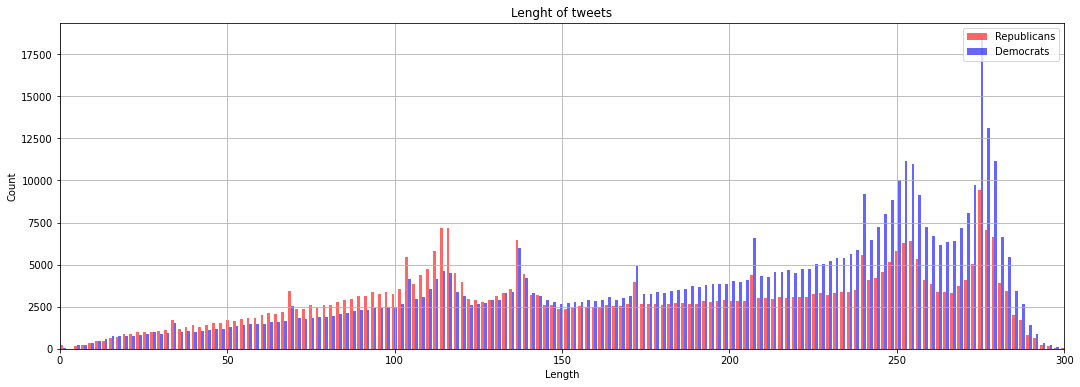

In [41]:
plt.rcParams['figure.figsize'] = (18, 6)
bins = 150
plt.title('Lenght of tweets')
plt.hist([df_republicans['length'], df_democrats['length']], alpha = 0.6, bins=bins, 
         label=['Republicans', 'Democrats'], color = ['r','b'])
plt.xlabel('Length');
plt.ylabel('Count');
plt.legend(loc='upper right');
plt.xlim(0,300);
plt.grid();
plt.show();

### Characters in tweets

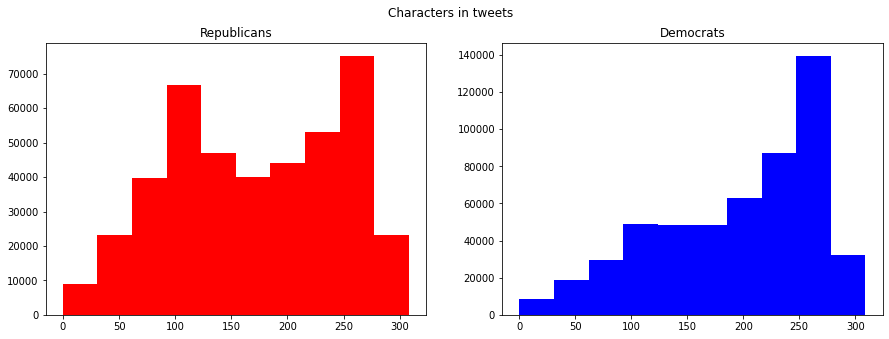

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
tweet_len_r=df_republicans['text'].str.len()
ax1.hist(tweet_len_r, color='r')
ax1.set_title('Republicans')
tweet_len_d=df_democrats['text'].str.len()
ax2.hist(tweet_len_d, color='b')
ax2.set_title('Democrats')
fig.suptitle('Characters in tweets')
plt.show()

### Temporal distribution of tweets by month

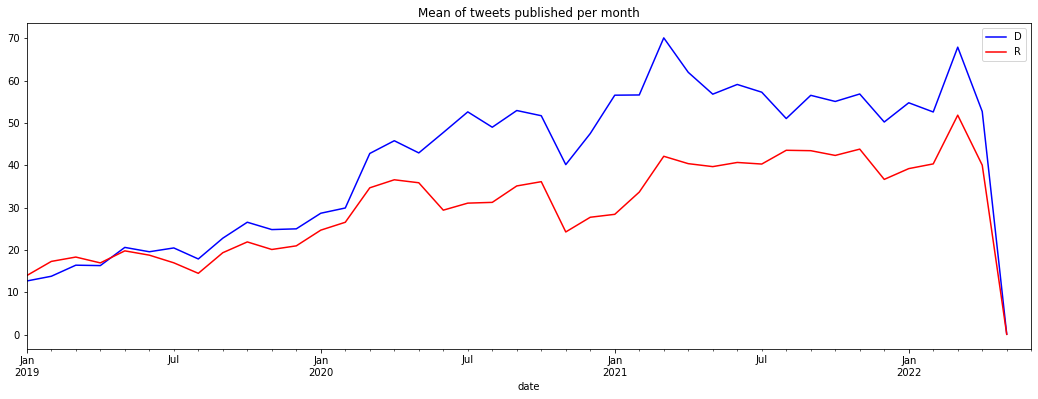

In [43]:
fig, ax = plt.subplots(figsize=(18, 6))

for label in df.label.unique():
    df_temp = df[df['label'] == label].copy()
    df_temp['date'] = pd.to_datetime(df_temp['created_at'].dt.strftime('%m/%Y'))
    number_users = df_temp.username.nunique()
    df_temp = df_temp.groupby(df_temp['date']).size()
    #Standarize by number of users
    df_temp = df_temp.divide(other = number_users)
    color = 'r' if label == 'R' else 'b'
    df_temp.plot(label=label, ax=ax, color=color)

ax.set_title('Mean of tweets published per month')
plt.xlim('01/2019','06/2022');
ax.legend();

There is a common peak in the first months of 2021 matching the EEUU elections and the Capitol riot.

### Number of words in tweets

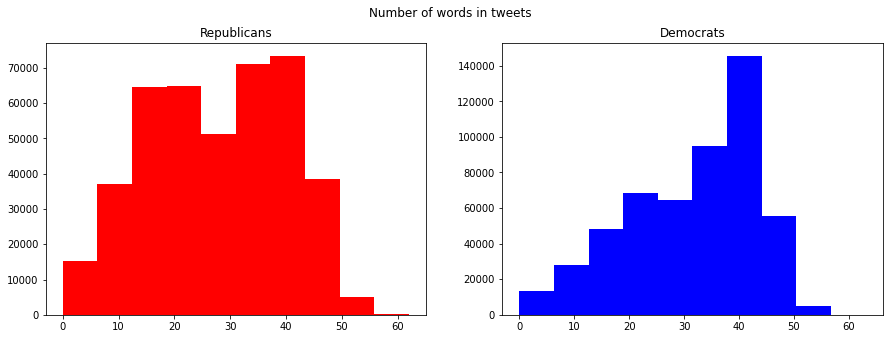

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
tweet_len_r=df_republicans['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len_r, color='r')
ax1.set_title('Republicans')
tweet_len_d=df_democrats['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len_d, color='b')
ax2.set_title('Democrats')
fig.suptitle('Number of words in tweets')
plt.show()

### Average word lenght in tweets

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py

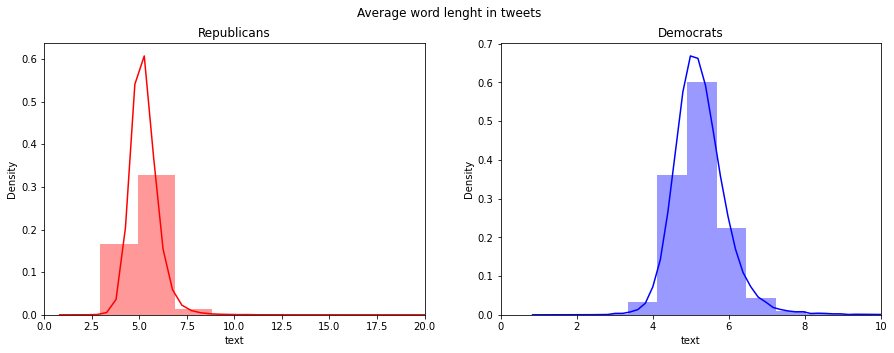

In [42]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
word=df_republicans['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='r')
ax1.set_title('Republicans')
ax1.set(xlim=(0, 20))
word=df_democrats['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='b')
ax2.set_title('Democrats')
ax2.set(xlim=(0, 10))
fig.suptitle('Average word lenght in tweets');

We can conclude that, for some reason, republicans tend to write shorter tweets, with less words, than democrats.

Before anything else, we have to tokenize tweets. This is a process that transforms a string containing a tweet to an array of strings, where each string is a character from that tweet. Method TweetTokenizer from library nltk helps us with this task:

In [23]:
from nltk.tokenize import TweetTokenizer

def create_corpus(label):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    corpus = []
    for x in df[df['label']==label]['text']:
        corpus += tokenizer.tokenize(x)
    return corpus

In [24]:
create_corpus(label='R')[:20]

['the',
 'failed',
 'economic',
 'policies',
 'of',
 'the',
 'biden',
 'administration',
 'are',
 'coming',
 'home',
 'to',
 'roost',
 '.',
 'this',
 'is',
 'a',
 'ridiculous',
 'statement',
 '.']

### Punctuation and strange characters in tweets

Tweets are going to contain a lot of punctuation signs, let's find out the most used ones:

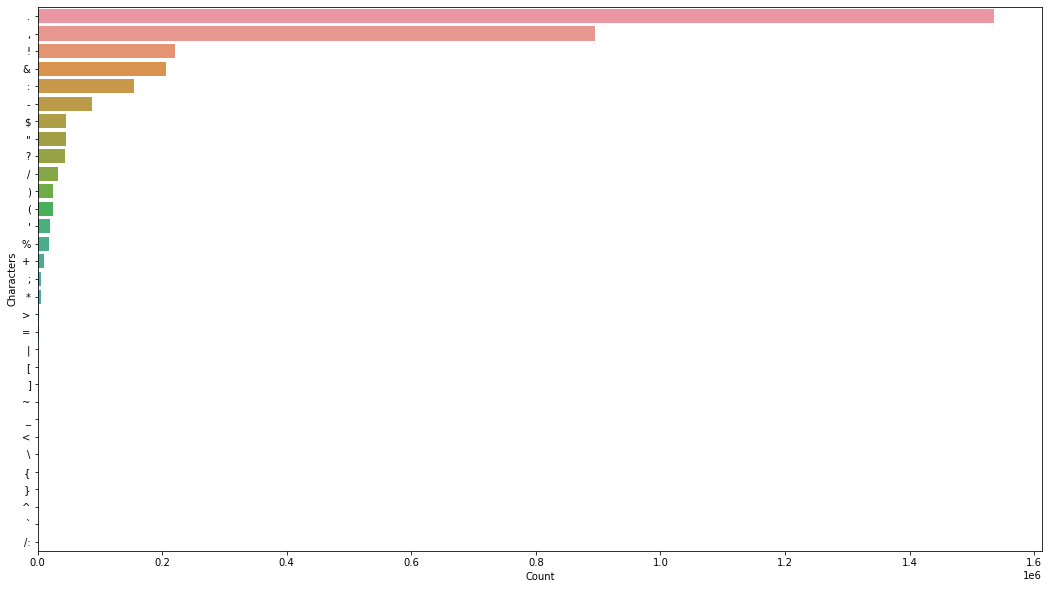

In [25]:
import string

plt.figure(figsize=(18,10))
list_of_words = create_corpus(label='R') + create_corpus(label='D')

punctuation = string.punctuation
special_characters = []

for word in list_of_words:
    if word in punctuation:
        special_characters.append(word)
        
special_characters_df = pd.DataFrame(special_characters, columns=['Characters'])
special_characters_df = special_characters_df.groupby('Characters').size().reset_index(name='Count').sort_values(by='Count', ascending=False)

sns.barplot(x=special_characters_df['Count'], y=special_characters_df['Characters']);

These will be removed in the future as they are not relevant for the model and are hindering us to see more useful information.

### Most common words in tweets

In [26]:
from collections import Counter

list_of_words_republicans = create_corpus(label='R')
list_of_words_democrats = create_corpus(label='D')
top_used_words_republicans = dict(Counter(list_of_words_republicans))
top_used_words_democrats = dict(Counter(list_of_words_democrats))
top_used_words_ordered_republicans = sorted(top_used_words_republicans.items(), key=lambda x: x[1], reverse=True)
top_used_words_ordered_democrats = sorted(top_used_words_democrats.items(), key=lambda x: x[1], reverse=True)
top_used_words_ordered_republicans[:5]

[('.', 633890),
 ('the', 562902),
 ('to', 473631),
 (',', 342400),
 ('and', 277238)]

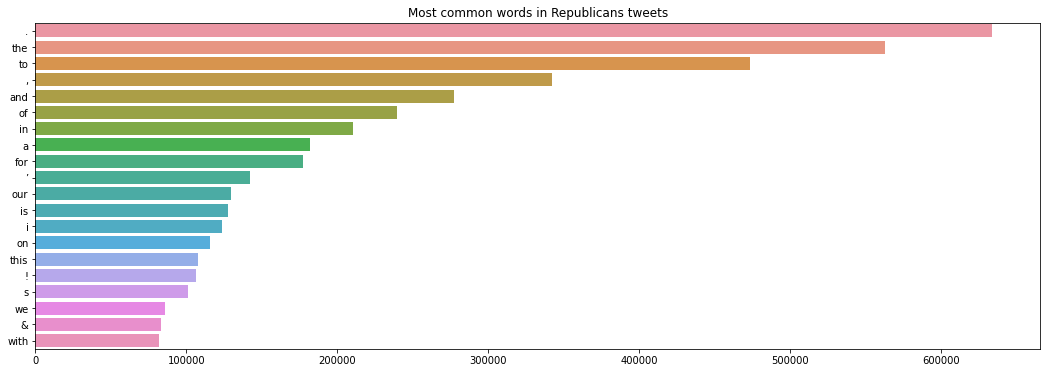

In [27]:
words = [i[0] for i in top_used_words_ordered_republicans[:20]]
count = [i[1] for i in top_used_words_ordered_republicans[:20]]
sns.barplot(x=count,y=words).set_title('Most common words in Republicans tweets');

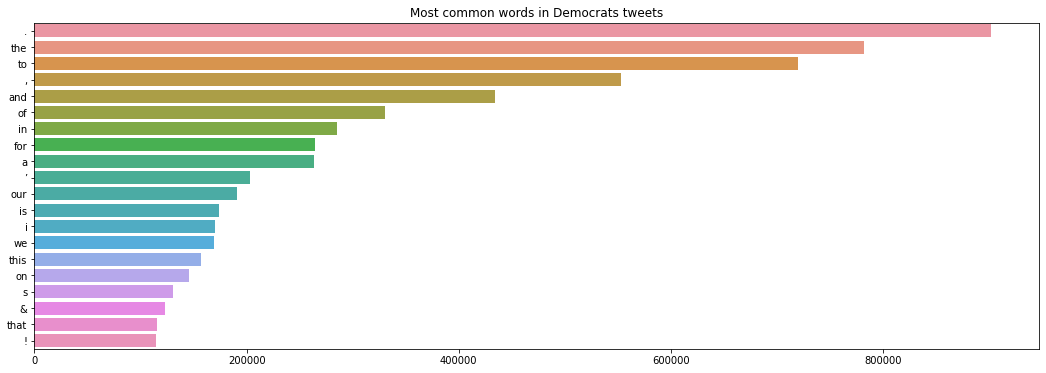

In [28]:
words = [i[0] for i in top_used_words_ordered_democrats[:20]]
count = [i[1] for i in top_used_words_ordered_democrats[:20]]
sns.barplot(x=count,y=words).set_title('Most common words in Democrats tweets');

As we can see, there are lots of punctuation signs and stop words, so let's delete them:

### Most common words in tweets which are not stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


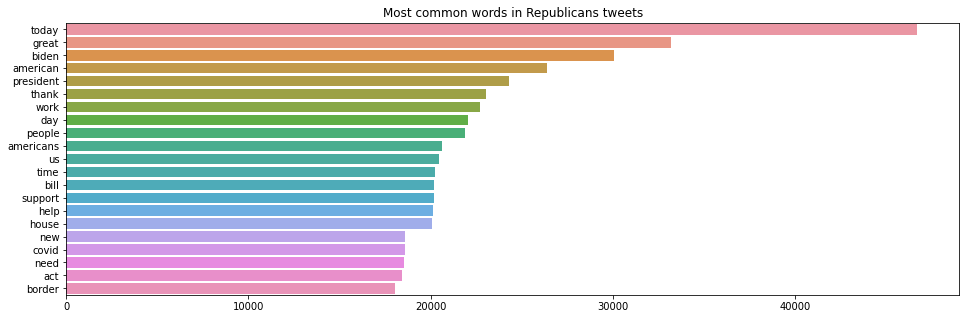

In [44]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=list(stopwords.words('english'))
import string
stop.extend(('&amp;', '-', '…', '’', '“', '—', '”', 'amp'))


words = []
count = []
list_of_rubish = ['&amp;', '-', '…', '’', '“', '—', '”', '✔', 'amp']
for word, number in top_used_words_ordered_republicans:
    if len(words) > 20:
        break
    elif (word not in stop) and (word not in string.punctuation):
        words.append(word)
        count.append(number)
plt.figure(figsize=(16,5))
sns.barplot(x=count,y=words).set_title('Most common words in Republicans tweets');

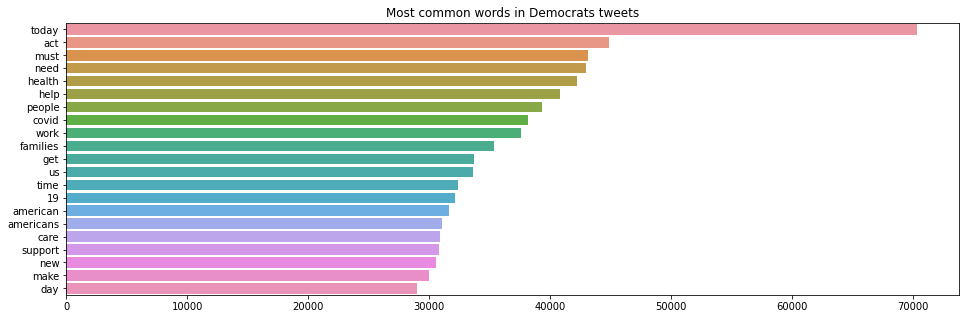

In [45]:
words = []
count = []
for word, number in top_used_words_ordered_democrats:
    if len(words) > 20:
        break
    elif (word not in stop) and (word not in string.punctuation):
        words.append(word)
        count.append(number)
plt.figure(figsize=(16,5))
sns.barplot(x=count,y=words).set_title('Most common words in Democrats tweets');

Now we start to see some useful information!

### Most common pairs of words in tweets

In [46]:
def create_list_of_bigrams_new(label):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    list_of_bigrams=[]
    
    for x in df[df['label']==label]['text']:
        corpus = tokenizer.tokenize(x)
        corpus_cleaned = []
        for word in corpus:
            if (word not in stop) and (word not in string.punctuation):
                corpus_cleaned.append(word)
        for i in range(len(corpus_cleaned)-1):
            list_of_bigrams.append(tuple(corpus_cleaned[i:i+2]))
    return list_of_bigrams

In [32]:
list_of_bigrams_republicans = create_list_of_bigrams_new(label='R')
list_of_bigrams_democrats = create_list_of_bigrams_new(label='D')

In [33]:
top_used_bigrams_republicans = dict(Counter(list_of_bigrams_republicans))
top_used_bigrams_democrats = dict(Counter(list_of_bigrams_democrats))
top_used_bigrams_ordered_republicans = sorted(top_used_bigrams_republicans.items(), key=lambda x: x[1], reverse=True)
top_used_bigrams_ordered_democrats = sorted(top_used_bigrams_democrats.items(), key=lambda x: x[1], reverse=True)
top_used_bigrams_ordered_republicans[:5]

[(('covid', '19'), 13682),
 (('president', 'biden'), 6644),
 (('🇺', '🇸'), 6487),
 (('⬇', '️'), 6121),
 (('small', 'businesses'), 6028)]

In [34]:
#transform the bigrams from tuple to string
for i in range(len(top_used_bigrams_ordered_republicans)):
    top_used_bigrams_ordered_republicans[i] = (" ".join(top_used_bigrams_ordered_republicans[i][0]), top_used_bigrams_ordered_republicans[i][1])
for i in range(len(top_used_bigrams_ordered_democrats)):
    top_used_bigrams_ordered_democrats[i] = (" ".join(top_used_bigrams_ordered_democrats[i][0]), top_used_bigrams_ordered_democrats[i][1])

In [35]:
top_used_bigrams_ordered_republicans[:20]

[('covid 19', 13682),
 ('president biden', 6644),
 ('🇺 🇸', 6487),
 ('⬇ ️', 6121),
 ('small businesses', 6028),
 ('american people', 6026),
 ('men women', 5600),
 ('biden administration', 4976),
 ('joe biden', 4898),
 ('united states', 4563),
 ('law enforcement', 4233),
 ('health care', 4151),
 ('southern border', 4128),
 ('look forward', 4119),
 ('president trump', 3624),
 ('national security', 3573),
 ('last week', 3401),
 ('last night', 3380),
 ('➡ ️', 3296),
 ('every day', 3104)]

Text(0.5, 1.0, 'Most common pairs of words in Republicans tweets')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


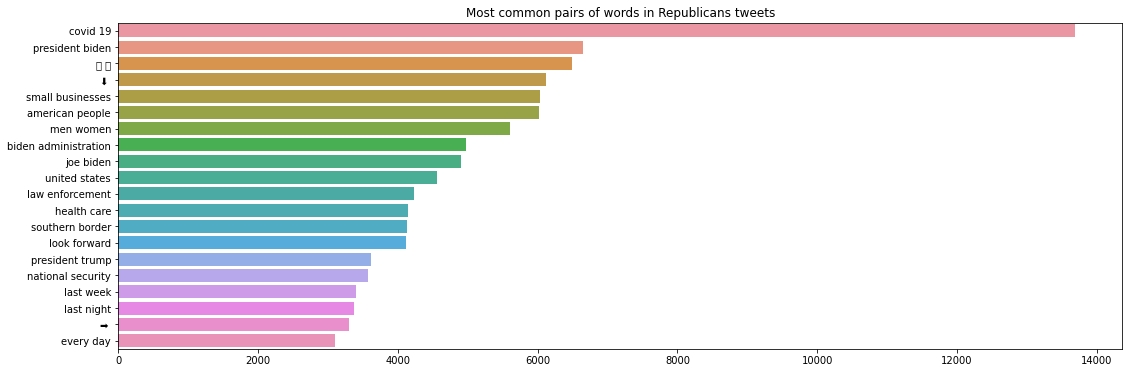

In [36]:
x,y=map(list,zip(*top_used_bigrams_ordered_republicans[:20]))
sns.barplot(x=y,y=x).set_title('Most common pairs of words in Republicans tweets')

Text(0.5, 1.0, 'Most common pairs of words in Democrats tweets')

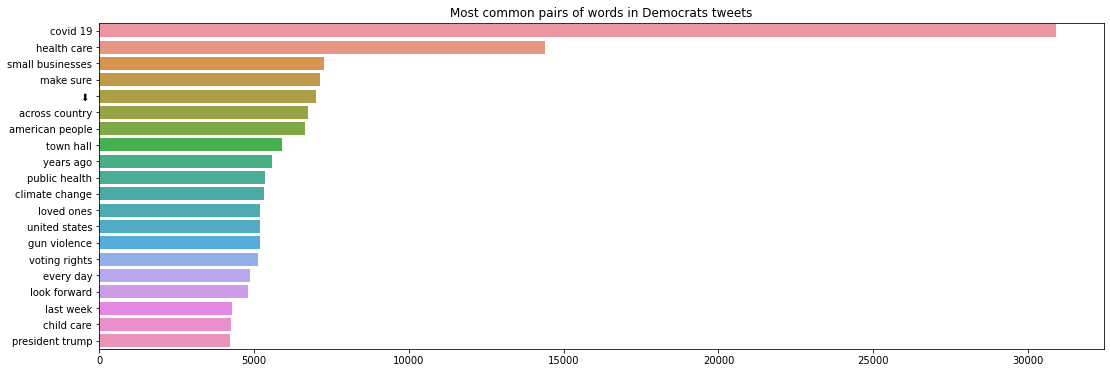

In [37]:
x,y=map(list,zip(*top_used_bigrams_ordered_democrats[:20]))
sns.barplot(x=y,y=x).set_title('Most common pairs of words in Democrats tweets')

## DOWNLOAD DF

In [40]:
import pyarrow as pa
import pyarrow.orc as orc
from google.colab import files

table = pa.Table.from_pandas(df, preserve_index=False)
orc.write_table(table, 'working_df.orc')
files.download('working_df.orc')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>